<a href="https://colab.research.google.com/github/seonae0223/Deep_Learning/blob/main/09_%EC%98%A4%EC%B0%A8_%EC%97%AD%EC%A0%84%ED%8C%8C%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%8B%A0%EA%B2%BD%EB%A7%9D_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

# ReLU Layer

In [ ]:
class ReLU:

  def __init__(self):
    # mask -> 순전파 때 음수 였던 위치를 마스킹.
    #         역전파 때 음수 였떤 부분을 0으로 내보낼 수 있도록 할 예정
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0) # [1, -1, 3, -2] -> [ F, T, F, T ]
    out = x.copy() # copy를 하지 않으면 원래 입력된 데이터 자체가 변경

    out[self.mask] = 0 # 음수인 부분을 0으로 만들어 준다.
    return out

  def backward(self, dout):
    '''
      dout : 뒤에서 부터 전달된 미분값이 들어있는 배열이 들어온다.
    '''
    dout[self.mask] = 0 # 예를 들어 순전파 때 [+, -, +] 들어왔으면
                        # 역전파 수행 시에 - 였던 부분을 0으로 만들어 준다.

    dx = dout
    return dx

In [ ]:
x = np.array([[1.0, -0.5],
              [-2.0, 3.0]])

relu = ReLU()
relu.forward(x)

array([[1., 0.],
       [0., 3.]])

In [ ]:
dout = np.array([[-1.0, 0.5],
                 [-2.0, 3.0]])

relu.backward(dout)

array([[-1.,  0.],
       [ 0.,  3.]])

# $\sigma$(시그모이드) 구현
$$
\sigma(x) = \frac{\mathrm{1} }{\mathrm{1} + exp(-x)}
$$

$$
y = \sigma(x)
$$

$$
y' = \sigma(x)(1-\sigma(x))
$$

$$
y' = y(1-y)
$$

* 시그모이드 레이어에서 순전파 때 기억하고 있어야 할 값 : $y$값만 알고 있으면 된다.

In [ ]:
class Sigmoid:

  def __init__(self):
    # 순전파 때 구한 y를 역전파(도함수) 수행시에 y(1-y)를 계산
    self.out = None

  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out

    return out

  def backward(self, dout):
    dx = dout * self.out * (1 - self.out) # dout * y(1-y)
    return dx

# Linear(Dense, FCL) 계층
* `forward`
  1. 입력값 `x`와 가중치 `W`의 내적 + `b` (`WX+b`)
  2. 평탄화
    * 1차원 배열로 데이터가 들어왔을 때 대응
    * 다차원 배열( 텐서 )에 대한 대응
    * **원본 데이터의 형상을 저장**
* `backward`
  1. 미분값(`dout`)과 가중치의 전치행렬(`W.T`) 내적 ( 입력값에 대한 미분값 )
  2. 입력값의 전치행렬(`X.T`)과 미분값(`dout`) 내적 ( 가중치에 대한 미분값 )
  3. 배치를 축으로 편향 합 구하기 (`axis=0`)
  4. 입력값의 미분값(`dx`)의 형상을 원본 `x`의 형상으로 다시 바꿔주기

`forward`에 의해서 형상(shape) 변환이 일어나기 때문에 `backward`할 때 원본 모양으로 되돌려 준다.
* `(100, 28, 28)`이 입력으로 들어오면, `forward`에서 평탄화에 의해 `(100, 784)`가 된다.
* 텐서에도 모두 내적을 수행할 수 있도록 원본 형상인 `(100, 28, 28)`저장을 해 놨다가 `backward`할 때 저장했던 원본 모양으로 **미분값 배열**의 형상을 되돌려 준다.

**저장해야 할 값**
1. 원본 `x`의 형상(shape)
2. 원본 `x` 데이터
3. 가중치, 편향
4. `dW`, `db`
  * 미분값을 알고 있어야 나중에 최적화( Optimization )를 할 수 있다.

In [ ]:
class Linear:
  def __init__(self, W, b):
    # 1. 가중치, 편향
    self.W = W
    self.b = b

    self.x = None

    # 2. [쓰잘데기 없는거] x의 shape 저장
    self.original_x_shape = None

    # 3. W와 b의 기울기 배열 저장
    #    최적화(Optimization)를 위해 각 매개변수의 미분값이 필요하기 때문
    #    추후 경사하강법 구현 시에 사용됨.
    self.dW = None
    self.db = None

  def forward(self, x):
    # [쓰잘데기 없는거]텐서 대응을 위해 입력 값 x의 shape을 저장
    #    ex) x가 (3, 2, 2) -> 3개의 데이터가 (2, 2)의 모양으로 들어옴
    # 근데 이거를 선형연산 할거면(XW) (3, 2*2)형식으로 평탄화를 해야 함
    # 그래서 미분값이 (3, 4)의 형태로 들어온다.

    # 역전파 수행 시에 가중치 방향으로 곱하기 위해 저장    # 따라서 마지막에 x쪽으로 미분값 전달 시에는 다시 (3, 2, 2)형식으로 바꿔야 함
    self.original_x_shape = x.shape

    # 평탄화 수행
    DATA_SIZE = x.shape[0] # 배치 사이즈 가져오기
    x = x.reshape(DATA_SIZE, -1)

    self.x = x

    out = self.x @ self.W + self.b # (N, M) @ (M, K) + (K, )
                                  #   ==> (N, K)
    return out

  def backward(self, dout): # dout의 shape -> (N, K)
    # 입력값에 내보내는 미분값 계산
    dx = dout @ self.W.T # 델타 @ 가중치 # (N, K) @ (K, M) -> (N, M)

    self.dW = self.x.T @ dout # (M, N) @ (N, K) -> (M, K)
    self.db = np.sum(dout, axis=0) # (N, K) -> (K, )

    return dx

# SoftmaxWithLoss 계층(출력층)
* softmax에 의한 분류 및 CEE를 활용한 손실함수를 동시에 구현
* `forward`
  * 순전파 시에는 softmax를 적용하고, loss를 적용
    * 정답 레이블(`t`)
    * 예측값( 소프트맥스 결과물 )
    * loss값 ( 기록용 )
* `backward`
  * 순수한 오차 (`y-t`)를 구해서 이전층에 전달
  * 주의사항 : t가 OHE가 되어있는지, 안 되어있는지에 따라서 코드가 달라짐

In [ ]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 값 복원
        it.iternext()

    return grad

In [ ]:
class SoftmaxWithLoss:

  def __init__(self):
    self.loss = None # 손실값 (시각화 할 때 사용할 예정..)
    self.y    = None # 예측값 ( 역전파 때 사용 )
    self.t    = None # 정답 레이블 ( 역전파 때 사용 )

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)

    return self.loss

  def backward(self, dout=1): # dout이 1인 이유 : d돈통 / d포스기 개념
    # 배치 고려하기
    batch_size = self.t.shape[0]

    # t가 원-핫 인코딩이 되어있는지, 안되어 있는지 고려
    if self.t.size == self.y.size: # 출력층의 원소 개수를 비교하는 것은 원-핫 인코딩이 되어있는 t
      # 항상 y는 softmax의 결과물 (N, OUTPUT_SIZE)
      # t가 OHE가 되어 있으면 (N, OUTPUT_SIZE)
      # t가 OHE가 안되어 있으면 (N, )
      dx = (self.y - self.t) / batch_size
    else: # t가 OHE가 안되어 있는 경우
      dx = self.y.copy()

      # 원-핫 인코딩이 되어있지 않은 t는 정답 레이블의 인덱스로 생각할 수 있다.
      # y = [0.2, 0.1, 0.7], t = 2
      # dx[np.arange(batch_size), self.t] -> dx[0, 2] -> 0.7 -> 0.7 - 1 를 구하겠다는 이야기 이다. -> -0.3의 오차가 있다.
      dx[np.arange(batch_size), self.t] -= 1
      dx = dx / batch_size

    return dx

# 신경망 모델 구축

In [ ]:
# OrderedDict : 순서가 있는 딕셔너리
from collections import OrderedDict

# 2층 신경망 구현
class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    # 매개변수(W, b) 초기화 (모델 파라미터 -> 미분이 가능해야 한다.)
    self.params = {}

    # 1층 은닉층을 위한 파라미터
    self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params["b1"] = np.zeros(hidden_size)

    # 2층 출력층을 위한 매개변수
    self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params["b2"] = np.zeros(output_size)

    # 레이어 정의
    #  추가되는 레이어의 순서가 바뀌면 안되기 때문에 OrderedDict를 사용
    self.layers = OrderedDict()

    self.layers['linear_1'] = Linear(self.params["W1"],
                                     self.params["b1"])

    self.layers["relu"] = ReLU()

    self.layers["linear_2"] = Linear(self.params["W2"],
                                     self.params["b2"])

    # 항상 제일 마지막 층은 SoftmaxWithLoss
    self.last_layer = SoftmaxWithLoss()

  def predict(self, x):
    # 순전파가 실행된다.
    #  각 레이어의 forward 함수를 순서대로 실행
    for layer in self.layers.values(): # 레이어만 순서대로 뽑아오기
      x = layer.forward(x)

    return x

  def loss(self, x, t):
    y = self.predict(x)
    return self.last_layer.forward(y, t)

  def accuracy(self, x, t):
    # 예측을 하고, 정답이랑 얼마나 틀렸는지를 계산
    # 단, t가 원-핫 인코딩이 되어있는지, 안되어있는지가 중요!
    y = self.predict(x)
    y = np.argmax(y, axis=1) # 제일 큰 값 하나만 뽑자.( 제일 확률이 높은 곳에 위치한 인덱스를 갖는다. )

    # 원-핫 인코딩 처리
    # t.ndim != 1 --> t가 원핫 인코딩이 되어있는 상태라면
    # t에서 제일 높은 인덱스를 찾겠다.
    if t.ndim != 1 : t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])

    return accuracy

  # 역전파를 활용한 각 매개변수의 기울기 배열 구하기
  def backward_propagation(self, x, t):
    # 오차역전파를 하기위해 필요한거
    #   1. 오차를 먼저 구해야 한다. 순전파가 먼저 일어 난다.
    self.loss(x, t)

    # 역전파
    dout = 1 # dL/dL --> d돈통/d포스기

    # SoftmaxWithLoss의 오차에 대한 미분값 구하기
    dout = self.last_layer.backward(dout) # 순수한 오차 y-t

    # 은닉층에 해당하는 레이어만 받아와서 뒤집기
    hidden_layers = list(self.layers.values()) # 순서대로 되어있는 레이어
    hidden_layers.reverse() # 뒤집기

    # 순서가 뒤집어진 레이어를 하나씩 꺼내서
    for layer in hidden_layers:
      # 미분값을 집어 넣어가면서 역전파!
      dout = layer.backward(dout)

    # 역전파가 끝났으면 각 레이어마다 기울기가 들어있음.(dW, db)
    #  Linear레이어에만 dW, db가 있음. ReLU에는 미분값이 없다.
    #   미분 값이 존재하는 레이어만 훈련할 수 있다.(trainable)

    # 구해진 미분값(기울기)를 꺼내서 저장
    grads = {}

    grads["W1"], grads["b1"] = self.layers["linear_1"].dW, self.layers["linear_1"].db
    grads["W2"], grads["b2"] = self.layers["linear_2"].dW, self.layers["linear_2"].db

    return grads

# 데이터 가져오기

In [ ]:
from tensorflow.keras import datasets
from sklearn.preprocessing import OneHotEncoder

mnist = datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

y_train_dummy = OneHotEncoder().fit_transform(y_train.reshape(-1, 1))
y_train_dummy = y_train_dummy.toarray()

y_test_dummy = OneHotEncoder().fit_transform(y_test.reshape(-1, 1))
y_test_dummy = y_test_dummy.toarray()

# feature 전처리
X_train = X_train.reshape(X_train.shape[0], -1)
X_train = X_train / 255.0 # 이미지 정규화 기법. 255.0 으로 나눠주면 모든 픽셀 데이터가 0 ~ 1사이의 값을 갖게 되고, 훈련이 쉽게 된다.

X_test = X_test.reshape(X_test.shape[0], -1)
X_test = X_test / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 훈련

In [ ]:
# 모델 생성
model = TwoLayerNet(
    input_size=28*28,
    hidden_size=100,
    output_size=10
)

In [ ]:
# 하이퍼 파라미터 설정
iter_nums = 10000 # 학습 반복 횟수
learning_rate = 0.1
batch_size= 100
train_size = X_train.shape[0]

# 훈련 과정을 1에폭마다 기록 (시각화 하기 위해)
train_loss_list = []
test_loss_list = []

train_acc_list = []
test_acc_list = []

In [ ]:
# 1 에폭에 필요한 훈련 횟수
iter_per_epoch = int(max(train_size / batch_size, 1)) # max를 쓴 이유 : 종종 train_size < batch_size 일 때는 한번만 학습

for i in range(iter_nums):
  # 미니 배치 생성
  batch_mask = np.random.choice(train_size, batch_size)
  X_batch = X_train[batch_mask]
  y_batch = y_train[batch_mask]

  # 훈련(경사하강법에 의한 가중치, 편향 갱신) 1단계 - 기울기 얻어내기
  grads = model.backward_propagation(X_batch, y_batch)

  # 기울기 얻어냈으면 경사하강법 수행(최적화 - Optimization)
  for key in ["W1", "b1", "W2", "b2"]:
    model.params[key] -= learning_rate * grads[key]

  # 1에폭 마다 정확도, loss 확인
  if i % iter_per_epoch == 0:
    train_loss = model.loss(X_batch, y_batch)
    test_loss  = model.loss(X_test, y_test)

    train_acc = model.accuracy(X_train, y_train)
    test_acc  = model.accuracy(X_test, y_test)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print("Epoch {} ==> Train Accuracy : {:.6f} / Test Accuracy : {:.6f} / Train Loss : {:.6f} / Test Loss : {:.6f} ".format(int(i/iter_per_epoch), train_acc, test_acc, train_loss, test_loss))

Epoch 0 ==> Train Accuracy : 0.118650 / Test Accuracy : 0.114500 / Train Loss : 2.299069 / Test Loss : 2.301428 
Epoch 1 ==> Train Accuracy : 0.906950 / Test Accuracy : 0.909600 / Train Loss : 0.234886 / Test Loss : 0.317258 
Epoch 2 ==> Train Accuracy : 0.926967 / Test Accuracy : 0.929500 / Train Loss : 0.149101 / Test Loss : 0.249719 
Epoch 3 ==> Train Accuracy : 0.939817 / Test Accuracy : 0.938500 / Train Loss : 0.090264 / Test Loss : 0.207985 
Epoch 4 ==> Train Accuracy : 0.948900 / Test Accuracy : 0.945400 / Train Loss : 0.126601 / Test Loss : 0.181371 
Epoch 5 ==> Train Accuracy : 0.955050 / Test Accuracy : 0.950900 / Train Loss : 0.094015 / Test Loss : 0.159373 
Epoch 6 ==> Train Accuracy : 0.961833 / Test Accuracy : 0.957500 / Train Loss : 0.130100 / Test Loss : 0.142748 
Epoch 7 ==> Train Accuracy : 0.963917 / Test Accuracy : 0.960900 / Train Loss : 0.075533 / Test Loss : 0.131674 
Epoch 8 ==> Train Accuracy : 0.968267 / Test Accuracy : 0.963000 / Train Loss : 0.073537 / Test 

# 훈련 / 테스트 결과 시각화

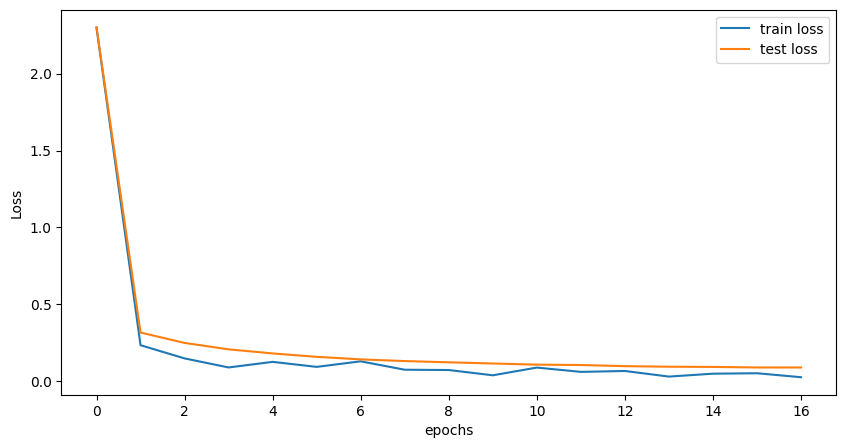

In [ ]:
import matplotlib .pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train loss")
plt.plot(np.arange(len(test_loss_list)), test_loss_list, label="test loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

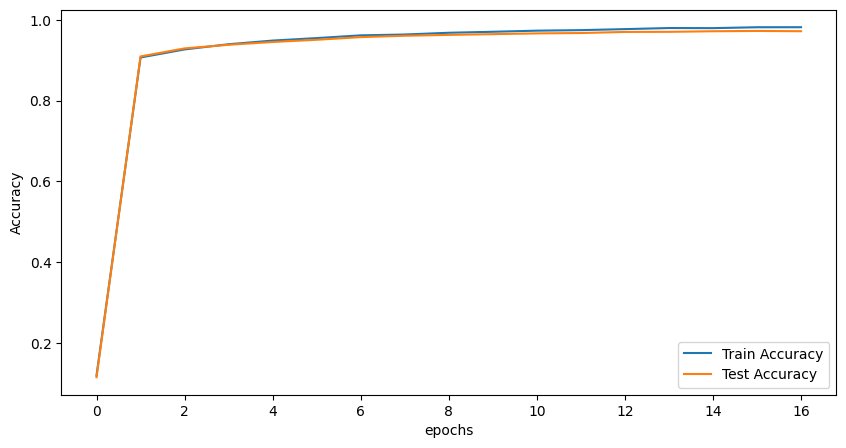

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(train_acc_list)), train_acc_list, label="Train Accuracy")
plt.plot(np.arange(len(test_acc_list)), test_acc_list, label="Test Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()